# Isotropic damage

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/isotropic_damage.ipynb)

In [1]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from torchfem.materials import IsotropicDamage3D

from torchfem.mesh import cube_hexa


torch.set_default_dtype(torch.float64)

In [2]:
# Number of elements per cube axis
N = 6

# Displacement boundary condition
U = 0.05

## Linear strain softening Material 

The material is elastic up to an equivalent strain (max. principal strain) of $\varepsilon_0$=0.005. From there on, the damage evolution is computed with a linear strain softening law. The fracture energy per unit area is 
$$
G_\textrm{f} = l_c  \int_{\varepsilon_0}^{\varepsilon_f} \sigma d \varepsilon = 10.0
$$
with the characteristic element length $l_c$.

In [3]:
# Elastic parameters (Young's modulus and Poisson's ratio)
E = 100e3
nu = 0.3

# Damage parameters (Damage initiation strain and fracture energy)
eps_0 = 0.005
G_f = 1.0 / N * 10.0


def d(kappa, cl):
    # Damage evolution law for linear strain softening
    eps_f = 2 * G_f / (E * eps_0 * cl) + eps_0
    evolution = (1 - eps_0 / kappa) * (eps_f / (eps_f - eps_0))
    evolution[kappa < eps_0] = 0.0
    evolution[kappa > eps_f] = 1.0

    return evolution


def d_prime(kappa, cl):
    # Derivative of the damage evolution law
    eps_f = 2 * G_f / (E * eps_0 * cl) + eps_0
    derivative = eps_0 * eps_f / (eps_f - eps_0) * kappa ** (-2)
    derivative[kappa < eps_0] = 0.0
    derivative[kappa > eps_f] = 0.0

    return derivative


# Elastic properties
material = IsotropicDamage3D(E, nu, d, d_prime, "rankine")

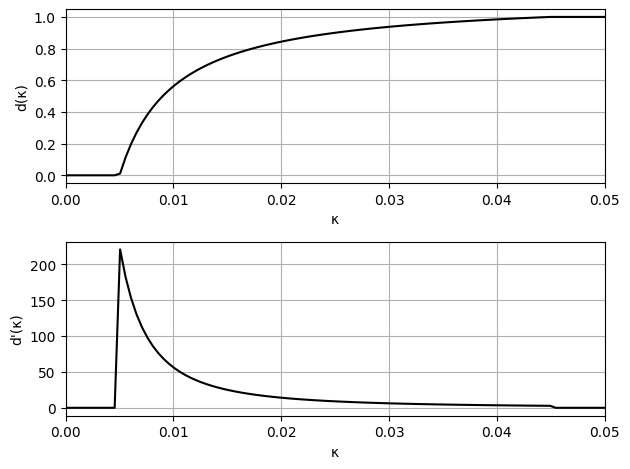

In [4]:
kappa_test = torch.linspace(0.0, U, 100)

fig, ax = plt.subplots(2, 1)
ax[0].plot(kappa_test, d(kappa_test, 1 / N), "-k")
ax[0].set_xlim(0.0, U)
ax[0].set_xlabel("κ")
ax[0].set_ylabel("d(κ)")
ax[0].grid()
ax[1].plot(kappa_test, d_prime(kappa_test, 1 / N), "-k")
ax[1].set_xlim(0.0, U)
ax[1].set_xlabel("κ")
ax[1].set_ylabel("d'(κ)")
ax[1].grid()
plt.tight_layout()
plt.show()

## Box-like domain
The domain is a unit cube which is loaded uniaxial.

In [5]:
# Generate cube
nodes, elements = cube_hexa(N + 1, N + 1, N + 1)

box = Solid(nodes, elements, material)

# Set constraints
box.displacements[nodes[:, 0] == 1.0, 0] = U
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

## Load path 
We apply the load in two steps:
1) The first step leads to partial damage and corresponding softening of the material 
2) Completely unloading should verify that the stress follows a straight line back to the origin. 
3) Finally, loading until full fracture should follow the previous unloading curve and then continue on the strain softening curve.

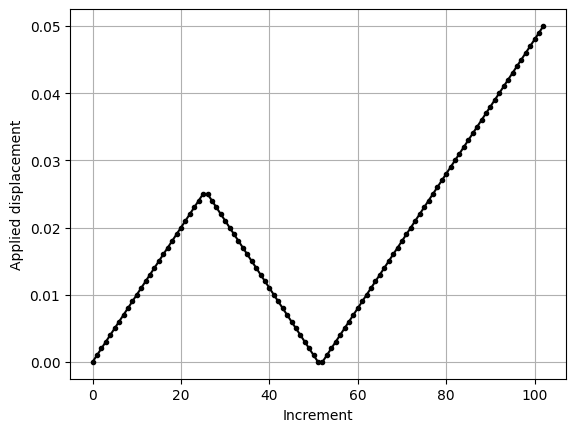

In [6]:
# Incremental loading
increments = torch.cat(
    (
        torch.linspace(0.0, 0.5, 26),
        torch.linspace(0.5, 0.0, 26),
        torch.linspace(0.0, 1.0, 51),
    )
)

plt.plot(increments * U, ".-k")
plt.xlabel("Increment")
plt.ylabel("Applied displacement")
plt.grid()
plt.show()

## Solve

In [7]:
u, f, σ, F, α = box.solve(increments=increments, return_intermediate=True)

ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(3)

## Results

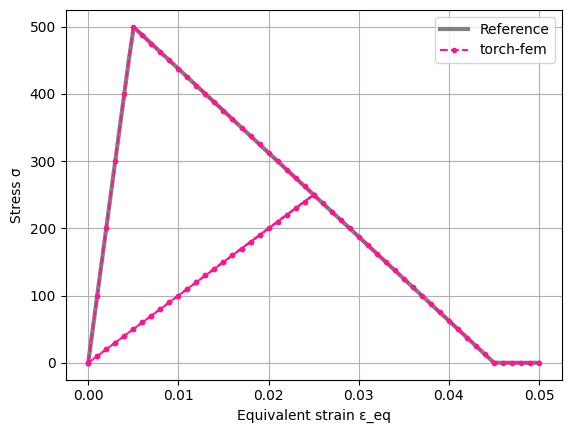

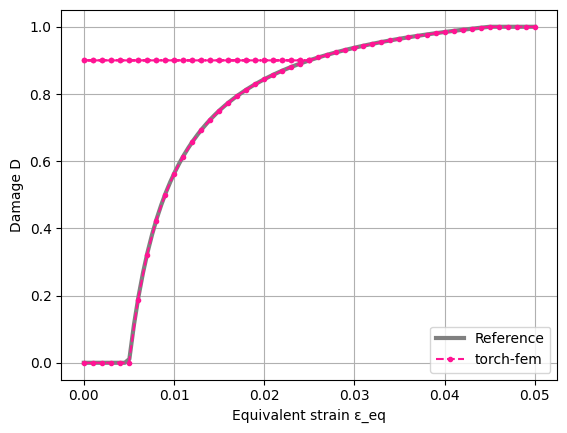

In [8]:
eps_test = torch.linspace(0, U, 100)
plt.plot(
    eps_test,
    (1 - d(eps_test, 1 / N)) * E * eps_test,
    color="gray",
    linewidth=3,
    label="Reference",
)
plt.plot(
    ε[:, :, 0, 0].mean(dim=1),
    σ[:, :, 0, 0].mean(dim=1),
    ".--",
    color="deeppink",
    label="torch-fem",
)


plt.xlabel("Equivalent strain ε_eq")
plt.ylabel("Stress σ")
plt.grid()
plt.legend()
plt.show()


plt.plot(
    eps_test,
    d(eps_test, 1 / N),
    color="gray",
    linewidth=3,
    label="Reference",
)
plt.plot(
    ε[:, :, 0, 0].mean(dim=1),
    α[:, :, 1].mean(dim=1),
    ".--",
    color="deeppink",
    label="torch-fem",
)

plt.xlabel("Equivalent strain ε_eq")
plt.ylabel("Damage D")
plt.grid()
plt.legend()
plt.show()